# Corn Disease Classification using EfficientNetB0

This notebook implements corn disease classification using the EfficientNetB0 architecture with transfer learning.

In [27]:
# Install required packages
%pip install tensorflow==2.17.0 kagglehub matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import kagglehub
import numpy as np
import matplotlib.pyplot as plt

In [29]:
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")
#data = r'C:\Users\Terrell\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1\data'
data = path + "/data"
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data, image_size=(224, 224), batch_size=32,
    validation_split=0.2, subset="training", seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data, image_size=(224, 224), batch_size=32,
    validation_split=0.2, subset="validation", seed=42
)

class_names = train_ds_raw.class_names
from tensorflow.keras.applications.efficientnet import preprocess_input

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.1)
])

def preprocess(ds, augment=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(tf.data.AUTOTUNE)

train_ds = preprocess(train_ds_raw, augment=True).shuffle(1000)
val_ds = preprocess(val_ds_raw)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.


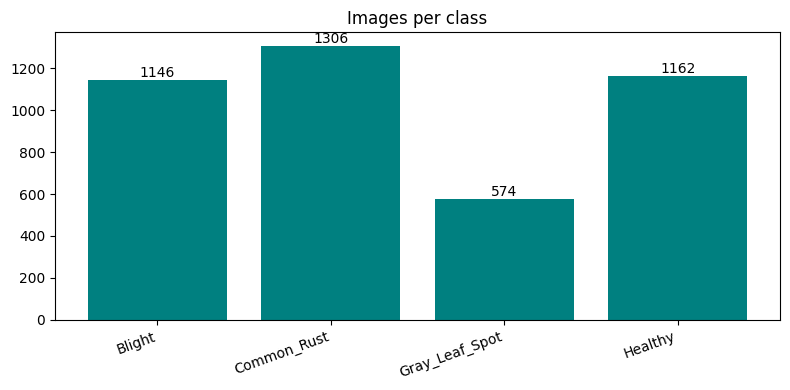

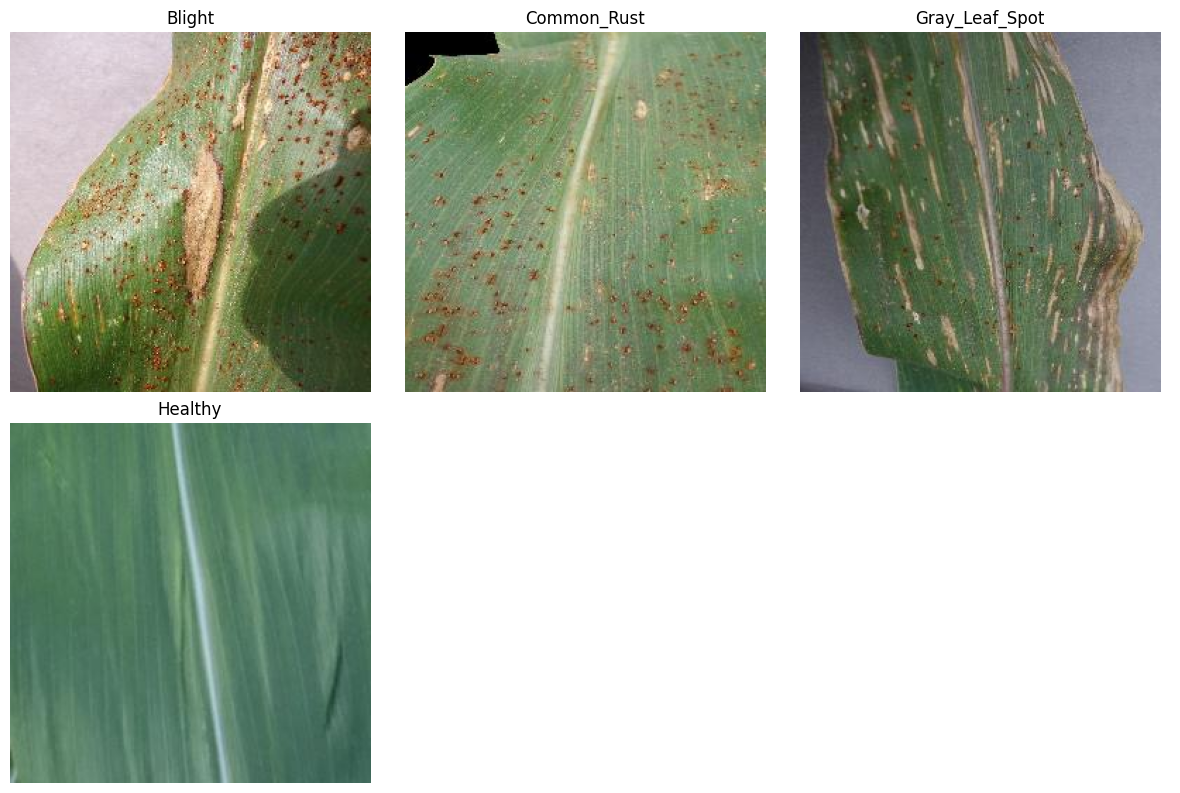

In [30]:
# Visualize class counts and sample images
from pathlib import Path
import random

data_dir = Path(data)
class_counts = {
    cls: len([p for p in (data_dir / cls).iterdir() if p.is_file()])
    for cls in class_names
}

plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='teal')
plt.title('Images per class')
plt.xticks(rotation=20, ha='right')
for bar, cls in zip(bars, class_counts.keys()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), class_counts[cls],
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Show a sample image from each class
cols = 3 if len(class_names) > 3 else len(class_names)
rows = (len(class_names) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = np.atleast_1d(np.array(axes)).ravel()

for ax in axes:
    ax.axis('off')

for ax, cls in zip(axes, class_names):
    image_paths = [p for p in (data_dir / cls).iterdir() if p.is_file()]
    if not image_paths:
        continue
    img_path = random.choice(image_paths)
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [31]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
model = Model(inputs=base_model.input, outputs=Dense(len(class_names), activation='softmax')(x))

    
base_model.trainable = False

In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


105/105 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.7622 - loss: 0.7205 - val_accuracy: 0.8757 - val_loss: 0.3848 - learning_rate: 1.0000e-04
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9060 - loss: 0.3035 - val_accuracy: 0.8973 - val_loss: 0.2833 - learning_rate: 1.0000e-04
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9275 - loss: 0.2305 - val_accuracy: 0.9188 - val_loss: 0.2388 - learning_rate: 1.0000e-04
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9329 - loss: 0.1960 - val_accuracy: 0.9223 - val_loss: 0.2219 - learning_rate: 1.0000e-04
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9388 - loss: 0.1742 - val_accuracy: 0.9271 - val_loss: 0.2021 - learning_rate: 1.0000e-04
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9481 - loss: 0.1574 - val_accuracy: 0.9283 - val_loss: 0.1957 - learning_rate: 1.0000e-04
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.95

In [33]:
#After fitting for the first time:
base_model.trainable = True

fine_tune_at = 250

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9633 - loss: 0.1165 - val_accuracy: 0.9427 - val_loss: 0.1767
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 103s 986ms/step - accuracy: 0.9591 - loss: 0.1171 - val_accuracy: 0.9438 - val_loss: 0.1762
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9627 - loss: 0.1154 - val_accuracy: 0.9450 - val_loss: 0.1750
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9615 - loss: 0.1141 - val_accuracy: 0.9450 - val_loss: 0.1746
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 103s 985ms/step - accuracy: 0.9642 - loss: 0.1138 - val_accuracy: 0.9450 - val_loss: 0.1739


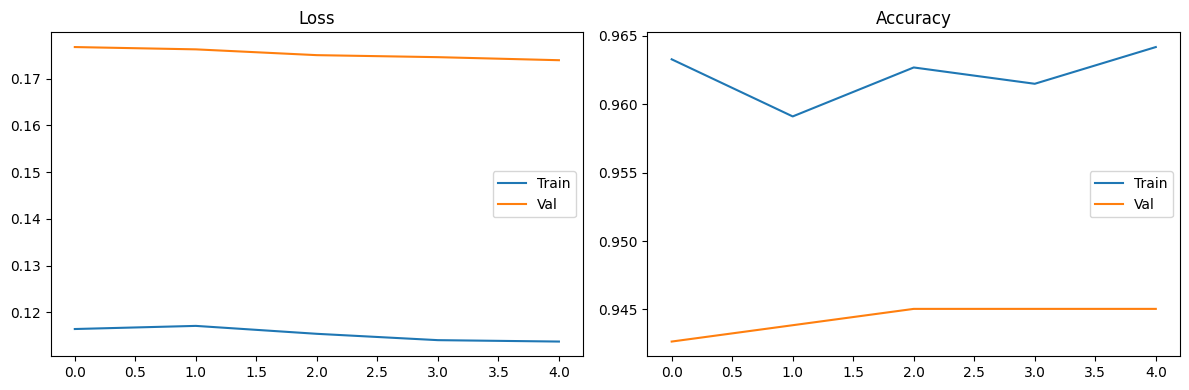

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(val_ds), axis=1)
y_true = np.concatenate([y for _, y in val_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 991ms/step
Classification Report:
                precision    recall  f1-score   support

        Blight       0.87      0.96      0.91       225
   Common_Rust       0.99      0.97      0.98       244
Gray_Leaf_Spot       0.90      0.77      0.83       126
       Healthy       1.00      1.00      1.00       242

      accuracy                           0.95       837
     macro avg       0.94      0.92      0.93       837
  weighted avg       0.95      0.95      0.94       837


Confusion Matrix:
[[216   0   8   1]
 [  5 236   3   0]
 [ 27   2  97   0]
 [  0   0   0 242]]


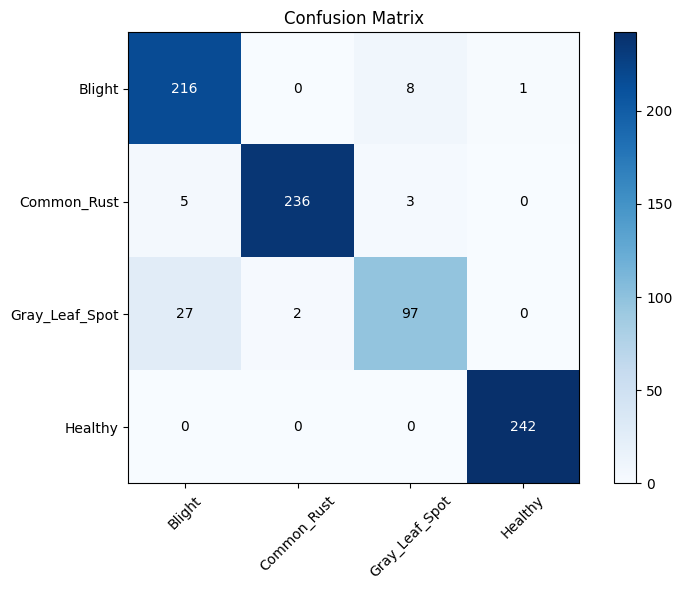

In [36]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()

In [37]:
#want to get just accuracy from model
loss, accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", accuracy)
print('Loss:', loss)

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 752ms/step - accuracy: 0.9450 - loss: 0.1739
Validation Accuracy: 0.945041835308075
Loss: 0.17391887307167053


In [38]:
#test with image.png
import numpy as np
from tensorflow.keras.preprocessing import image
img_path = 'C:\\Users\\Terrell\\Mad_Corn_Disease-1\\extra pictures\\Blight\\image.png'  # replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
img_array = img_array / 255.0  # Rescale if necessary
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", class_names[predicted_class[0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: Common_Rust


In [40]:
np.save("EfficientNetHistory.npy", history.history) # Export